# SDXL Model Pipeline Setup - Lightning Fix Applied
Supports 9 distillation models with proper scheduler configuration

In [22]:
# Imports and Configuration
import sys
import torch
from PIL import Image
from diffusers import (
    UNet2DConditionModel,
    StableDiffusionXLPipeline,
    EulerAncestralDiscreteScheduler,
    EulerDiscreteScheduler,
    DDIMScheduler,
    LCMScheduler,
    TCDScheduler,
    DiffusionPipeline,
)
from huggingface_hub import hf_hub_download
from safetensors.torch import load_file

%load_ext autoreload
%autoreload 2

print("✓ Imports completed")

# ---------- Configuration ----------
device = "cuda"
weights_dtype = torch.bfloat16
basemodel_id = "stabilityai/stable-diffusion-xl-base-1.0"


model_configs = {
    'base': {'steps': 100, 'recommended_cfg': 5.5},
    'dmd2': {'steps': 4, 'recommended_cfg': 0.0},
    'turbo': {'steps': 4, 'recommended_cfg': 0.0},
    'lightning': {'steps': 4, 'recommended_cfg': 0.0},
#    'lcm': {'steps': 4, 'recommended_cfg': 1.0},
#    'hyper': {'steps': 8, 'recommended_cfg': 5.0},
#    'pcm': {'steps': 4, 'recommended_cfg': 2.0},
#    'tcd': {'steps': 4, 'recommended_cfg': 3.0},
#    'flash': {'steps': 4, 'recommended_cfg': 2.0}
}

print(f"✓ Configuration set - Device: {device}, Dtype: {weights_dtype}")
print(f"✓ Available models: {list(model_configs.keys())}")


BASE_ID = "stabilityai/stable-diffusion-xl-base-1.0"

def load_pipe(model_name: str, device: str = "cuda", dtype: torch.dtype = torch.float16):
    """
    Canonical assembly per method; returns a ready-to-sample pipeline.
    model_name one of:
      'base', 'dmd2', 'lightning', 'turbo', 'lcm', 'hyper', 'pcm', 'tcd', 'flash'
    """
    name = model_name.strip().lower()

    if name == "base":
        pipe = StableDiffusionXLPipeline.from_pretrained(basemodel_id, torch_dtype=dtype, variant="fp16")
        pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config)
        return pipe.to(device)

    # ---- DMD2 (UNet drop-in; LCM scheduler; 4-step timesteps) ----
    if name == "dmd2":
        unet = UNet2DConditionModel.from_config(basemodel_id, subfolder="unet").to(device, dtype)
        state = torch.load(hf_hub_download("tianweiy/DMD2", "dmd2_sdxl_4step_unet_fp16.bin"), map_location="cpu")
        unet.load_state_dict(state if isinstance(state, dict) else state["state_dict"])
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, unet=unet, torch_dtype=dtype, variant="fp16")
        pipe.scheduler = LCMScheduler.from_config(basemodel_id.scheduler.config)
        # Optionally: when sampling with 4 steps, use the training timesteps:
        pipe._dmd2_timesteps = [999, 749, 499, 249]
        return pipe.to(device)

    # ---- SDXL-Lightning (UNet/LoRA; EulerDiscrete w/ trailing; CFG=0) ----
    if name == "lightning":
        unet = UNet2DConditionModel.from_config(basemodel_id, subfolder="unet").to(device, dtype)
        state = load_file(hf_hub_download("ByteDance/SDXL-Lightning", "sdxl_lightning_4step_unet.safetensors"))
        unet.load_state_dict(state, strict=True)
        pipe = StableDiffusionXLPipeline.from_pretrained(basemodel_id, unet=unet, torch_dtype=dtype, variant="fp16")
        pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
        return pipe.to(device)

    # ---- SDXL-Turbo (use AutoPipeline; leave baked scheduler; CFG=0) ----
    if name == "turbo":
        pipe = AutoPipelineForText2Image.from_pretrained("stabilityai/sdxl-turbo", torch_dtype=dtype, variant="fp16")
        # Model card disables guidance; default scheduler from repo is fine.
        return pipe.to(device)

    # ---- LCM-LoRA (LCMScheduler; low steps; guidance ~0–2) ----
    if name == "lcm":
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=dtype, variant="fp16")
        pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config)
        pipe.load_lora_weights("latent-consistency/lcm-lora-sdxl")
        pipe.fuse_lora()
        return pipe.to(device)

    # ---- Hyper-SDXL (CFG-preserved N-steps LoRA; DDIM trailing) ----
    if name == "hyper":
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=dtype, variant="fp16")
        pipe.load_lora_weights("ByteDance/Hyper-SD",
                               weight_name="Hyper-SDXL-8steps-CFG-lora.safetensors")
        pipe.fuse_lora()
        pipe.scheduler = DDIMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
        return pipe.to(device)

    # ---- PCM (Phased Consistency Model LoRA; DDIM or Euler, trailing; special flags) ----
    if name == "pcm":
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=dtype, variant="fp16")
        pipe.load_lora_weights("wangfuyun/PCM_Weights",
                               weight_name="pcm_deterministic_4step_shift1.safetensors",
                               subfolder="sdxl")
        pipe.fuse_lora()
        pipe.scheduler = DDIMScheduler.from_config(
            pipe.scheduler.config, timestep_spacing="trailing", clip_sample=False, set_alpha_to_one=False
        )
        return pipe.to(device)

    # ---- TCD LoRA (TCDScheduler; guidance 0; set eta (aka gamma) as desired) ----
    if name == "tcd":
        pipe = StableDiffusionXLPipeline.from_pretrained(basemodel_id, torch_dtype=dtype, variant="fp16")
        pipe.scheduler = TCDScheduler.from_config(pipe.scheduler.config)
        pipe.load_lora_weights("h1t/TCD-SDXL-LoRA")
        pipe.fuse_lora()
        return pipe.to(device)

    # ---- Flash SDXL LoRA (LCM w/ trailing; guidance 0) ----
    if name == "flash":
        pipe = DiffusionPipeline.from_pretrained(basemodel_id, torch_dtype=dtype, variant="fp16")
        pipe.scheduler = LCMScheduler.from_config(pipe.scheduler.config, timestep_spacing="trailing")
        pipe.load_lora_weights("jasperai/flash-sdxl")
        pipe.fuse_lora()
        return pipe.to(device)

    raise ValueError(f"Unknown model_name: {model_name!r}")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
✓ Imports completed
✓ Configuration set - Device: cuda, Dtype: torch.bfloat16
✓ Available models: ['base', 'dmd2', 'turbo', 'lightning']


100%|██████████| 100/100 [00:10<00:00,  9.12it/s]


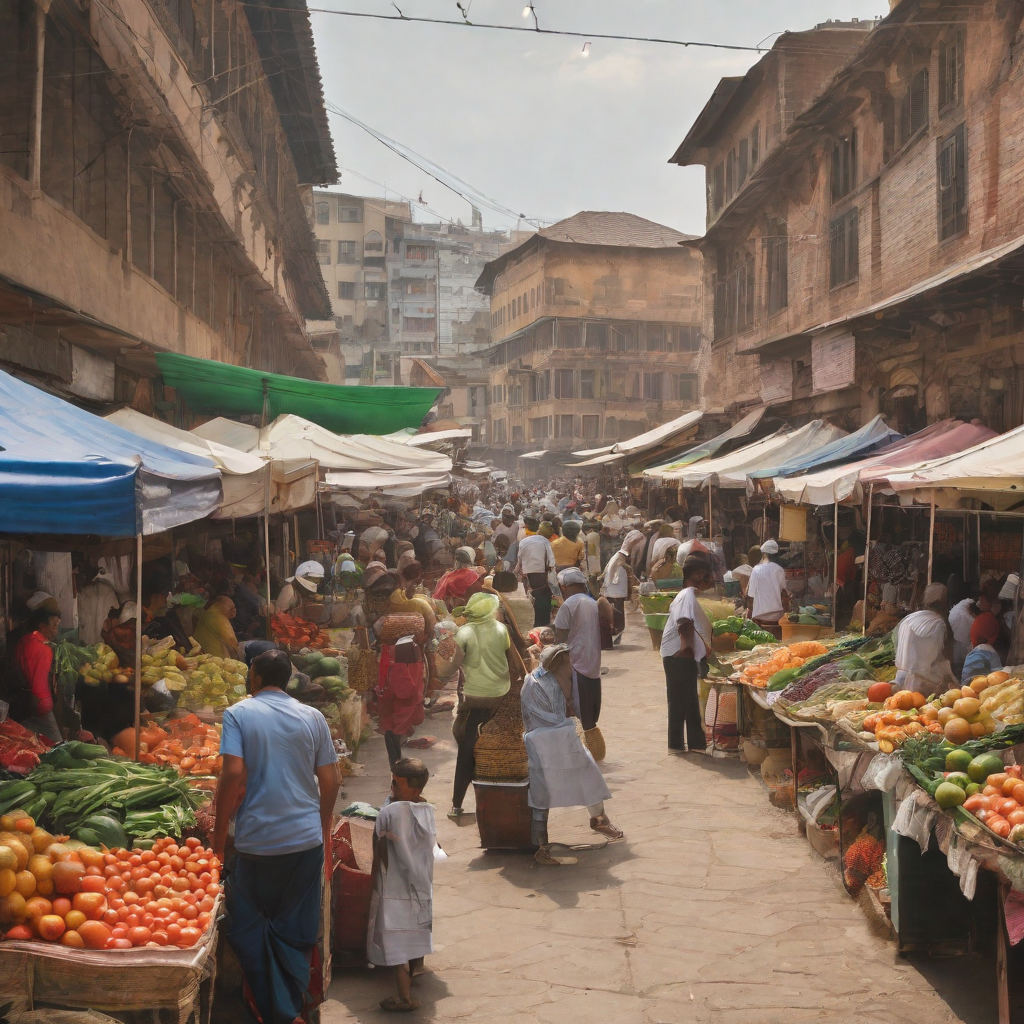

In [20]:
import torch
from diffusers import StableDiffusionXLPipeline

torch.backends.cuda.matmul.allow_tf32 = True        # A100-friendly speed
torch.set_float32_matmul_precision("high")          # prefer TF32 on fp32 ops

prompt = "A bustling marketplace with vendors selling fresh fruits and vegetables"

pipe = load_pipe("base")

# Generate a small batch efficiently on A100 (adjust batch_size as you like)
generator = torch.Generator(device="cuda").manual_seed(9934)
images = pipe(
    prompt=[prompt],            # batch of 4
    num_inference_steps=100,         # 25–40 typical
    guidance_scale=5.5,             # 4.5–7.0 works well
    height=1024,
    width=1024,
    generator=generator,
).images

images[0]

## Test Across Select Models
Run tests on multiple models with first 10 prompts and first seed, organized by model folder

In [23]:
import json
import os
from pathlib import Path
from tqdm import tqdm

# ---------- Load prompts from JSON file ----------
prompts_file = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json"
output_base_dir = "/home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results"

# Load prompts
with open(prompts_file, 'r') as f:
    prompts_data = json.load(f)

# Use only first 10 prompts
prompts_data = prompts_data[:10]

print(f"Loaded {len(prompts_data)} prompts from {prompts_file}")
print(f"Output base directory: {output_base_dir}")

# ---------- Generate and save images organized by folder ----------
total_generated = 0

for model_name, model_config in model_configs.items():
    steps = model_config["steps"]
    cfg = model_config["recommended_cfg"]
    
    # Load the model pipeline
    pipe = load_pipe(model_name)
    
    # Create model-specific output directory
    model_output_dir = os.path.join(output_base_dir, model_name)
    os.makedirs(model_output_dir, exist_ok=True)
    
    print(f"\n{'='*60}")
    print(f"Testing model: {model_name}")
    print(f"Output directory: {model_output_dir}")
    print(f"{'='*60}")
    
    generated_count = 0
    
    for idx, item in enumerate(tqdm(prompts_data, desc=f"{model_name} progress")):
        prompt = item["prompt"]
        print(f"\nPrompt {idx}: {prompt}")
        negative_prompt = item["negative_prompt"]
        seeds = item.get("seeds", [42])
        
        # Use first seed for quick generation
        seed = 9934
        
        try:
            # Generate image
            generator = torch.Generator(device=device).manual_seed(seed)
            image = pipe(
                prompt,
                guidance_scale=cfg,
                num_inference_steps=steps,
                generator=generator
            ).images[0]
            
            # Create output filename
            group = item.get("group", "unknown")
            filename = f"{idx:04d}_{group}_{seed}.png"
            filepath = os.path.join(model_output_dir, filename)
            
            # Save image
            image.save(filepath)
            generated_count += 1
            total_generated += 1
            
        except Exception as e:
            print(f"Error generating image for prompt {idx} with {model_name}: {e}")
            continue
    
    print(f"\n✓ {model_name}: Generated and saved {generated_count} images")

print(f"\n{'='*60}")
print(f"✓ Total generated and saved: {total_generated} images")
print(f"✓ Models tested: {list(model_configs.keys())}")
print(f"{'='*60}")

Loaded 10 prompts from /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/data/prompts_noun_negative.json
Output base directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  9.33it/s]



Testing model: base
Output directory: /home/azureuser/cloudfiles/code/Users/Normalized-Attention-Guidance/results/base


base progress:   0%|          | 0/10 [00:00<?, ?it/s]


Prompt 0: A bustling marketplace with vendors selling fresh fruits and vegetables


base progress:  10%|█         | 1/10 [00:11<01:46, 11.82s/it]


Prompt 1: A quiet library with people reading books at wooden tables


base progress:  20%|██        | 2/10 [00:23<01:34, 11.84s/it]


Prompt 2: A lively park with children playing on swings and slides


base progress:  30%|███       | 3/10 [00:35<01:22, 11.85s/it]


Prompt 3: A cozy coffee shop with patrons sipping lattes and typing on laptops


base progress:  40%|████      | 4/10 [00:47<01:11, 11.89s/it]


Prompt 4: A crowded subway station with commuters waiting for the next train


base progress:  50%|█████     | 5/10 [00:59<00:59, 11.91s/it]


Prompt 5: A scenic mountain trail with hikers trekking towards the summit


base progress:  60%|██████    | 6/10 [01:11<00:47, 11.89s/it]


Prompt 6: A sunny beach with people sunbathing under colorful umbrellas


base progress:  70%|███████   | 7/10 [01:23<00:35, 11.93s/it]


Prompt 7: A busy office with employees working at their desks and making phone calls


base progress:  80%|████████  | 8/10 [01:35<00:23, 11.97s/it]


Prompt 8: A vibrant street fair with artists painting and musicians performing


base progress:  90%|█████████ | 9/10 [01:47<00:11, 12.00s/it]


Prompt 9: A tranquil lake with ducks swimming and people kayaking


base progress: 100%|██████████| 10/10 [01:59<00:00, 11.94s/it]
/mnt/batch/tasks/shared/LS_root/mounts/clusters/a100-ml/code/Users/Normalized-Attention-Guidance/.venv/lib/python3.10/site-packages/diffusers/configuration_utils.py:250: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a model, please use <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.load_config(...) followed by <class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>.from_config(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)



✓ base: Generated and saved 10 images


Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00, 15.80it/s]


AttributeError: 'str' object has no attribute 'scheduler'